## 퍼셉트론 학습 알고리즘 구현

![](images/perceptron.jpeg)

- np.random.RandomState(n) : n값을 이용해 난수 생성. 지역에서 seed 생성한다. cf> np.random.seed()는 전역으로 생성 
- np.random.normal(loc=평균, scale=표준편차, size=shape)
- np.where(codition, [x, y]) : condition에 따라 x, y 중 하나를 반환한다.

In [1]:
import numpy as np

class Perceptron(object):
    def __init__(self, eta=0.01, n_iter=50, random_state=1):
        self.eta = eta
        self.n_iter = n_iter
        self.random_state = random_state
        
    def fit(self, X, y):
        rgen = np.random.RandomState(self.random_state)
        self.w_ = rgen.normal(loc=0.0, scale=0.01, size=1 + X.shape[1]) 
        self.errors_ = []
        
        for _ in range(self.n_iter):
            errors = 0
            for xi, target in zip(X, y):
                update = self.eta * (target - self.predict(xi)) 
                self.w_[1:] += update * xi    # w1 = 오차 * x1
                self.w_[0] += update          # w0 = 오차
                errors += int(update != 0.0)
            self.errors_.append(errors)       # 오차가 0이면 0을, 그렇지 않으면 오차를 errors에 추가
        return self
    
    def net_input(self, X):
        return np.dot(X, self.w_[1:] + self.w_[0])
    
    def predict(self, X):
        return np.where(self.net_input(X) >= 0.0, 1, -1)  # 출력값이 0 이상이면 1, 그렇지 않으면 -1

### iris dataset 불러오기

윈도우에서 url을 join하면 url과 달리 문자열 사이에 '\'가 포함된다. 이 때문인지 read_csv()할 때 에러가 발생한다. `\` 문자를 `/`로 바꾸면 정상 작동한다.

In [2]:
import os
import pandas as pd
s = os.path.join('https://archive.ics.uci.edu', 'ml', 'machine-learning-databases', 'iris', 'iris.data')
print('URL', s)
# df = pd.read_csv(s, header=None, encoding='utf-8')
df = pd.read_csv('https://archive.ics.uci.edu/ml/machine-learning-databases/iris/iris.data', header=None)
df.tail()

URL https://archive.ics.uci.edu/ml/machine-learning-databases/iris/iris.data


,0,1,2,3,4
145,6.7,3.0,5.2,2.3,Iris-virginica
146,6.3,2.5,5.0,1.9,Iris-virginica
147,6.5,3.0,5.2,2.0,Iris-virginica
148,6.2,3.4,5.4,2.3,Iris-virginica
149,5.9,3.0,5.1,1.8,Iris-virginica


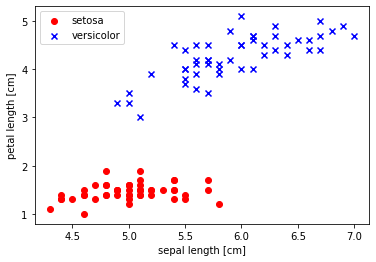

In [3]:
import matplotlib.pyplot as plt
import numpy as np

# setosa만 -1로, 나머지는 1로 바꿈
y = df.iloc[0:100, 4].values
y = np.where(y == 'Iris-setosa', -1, 1)

# 꽃받침 길이와 꽃잎 길이만 X에 담음
X = df.iloc[0:100, [0, 2]].values

plt.scatter(X[:50, 0], X[:50, 1], color='red', marker='o', label='setosa')
plt.scatter(X[50:100, 0], X[50:100, 1], color='blue', marker='x', label='versicolor')
plt.xlabel('sepal length [cm]')
plt.ylabel('petal length [cm]')
plt.legend(loc='upper left')
plt.show()

### 퍼셉트론으로 학습

에포크 대비 잘못 분류된 오차를 그래프로 그려, 두 붓꽃 클래스를 구분하는 결정 경계를 찾는지 확인

Text(0, 0.5, 'Number of updates')

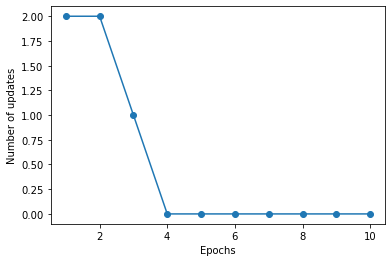

In [4]:
ppn = Perceptron(eta=0.1, n_iter=10)
ppn.fit(X, y)
plt.plot(range(1, len(ppn.errors_) + 1), ppn.errors_, marker='o')
plt.xlabel('Epochs')
plt.ylabel('Number of updates')

### 2차원 결정 경계 시각화

- 인자 classifier는 훈련된 모델, resolution은 최솟값과 최댓값 사이에 개별 축 값의 간격
- ListedColormap(color) : color를 그래프 상에 표시하는 객체 -> plt.contourf()의 인자로 사용됨
- np.unique(n) : n의 고윳값을 오름차순으로 반환
- np.meshgrid(x, y) : x, y 각 요소를 좌표로 하는 격자의 교차점 반환
- plt.contourf(x, y, z) : 등고선 출력, z는 높이

In [5]:
from matplotlib.colors import ListedColormap

def plot_decision_regions(X, y, classifier, resolution=0.02):
    
    markers = ('s', 'x', 'o', '^', 'v')
    colors = ('red', 'blue', 'lightgreen', 'gray', 'cyan')
    cmap = ListedColormap(colors[:len(np.unique(y))])   
    
    # 결정 경계 그림
    x1_min, x1_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    x2_min, x2_max = X[:, 1].min() - 1, X[:, 1].max() + 1
#     print(f'x1_min = {x1_min}, x1_max = {x1_max}')
    
    xx1, xx2 = np.meshgrid(np.arange(x1_min, x1_max, resolution),
                           np.arange(x2_min, x2_max, resolution))
#     print(f'xx1 = {xx1.shape}, \n{xx1}')
#     print(f'xx2 = {xx2.shape}, \n{xx2}')
    
    Z = classifier.predict(np.array([xx1.ravel(), xx2.ravel()]).T)
#     print(f'z.ravel = {len(Z)}, \n{Z}')
    
    Z = Z.reshape(xx1.shape)
#     print(f'z = {Z.shape}, \n{Z}')
    
    plt.contourf(xx1, xx2, Z, alpha=0.3, cmap=cmap)
    plt.xlim(xx1.min(), xx1.max())
    plt.ylim(xx2.min(), xx2.max())
    
    for idx, c1 in enumerate(np.unique(y)):
        plt.scatter(x=X[y == c1, 0],
                    y=X[y == c1, 1],
                    alpha=0.8,
                    c=colors[idx],
                    marker=markers[idx],
                    label=c1,
                    edgecolor='black')

/var/folders/_8/0hjw1jgs5fx2zkq05jtt6_6w0000gn/T/ipykernel_798/2475110485.py:30: UserWarning: You passed a edgecolor/edgecolors ('black') for an unfilled marker ('x').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  plt.scatter(x=X[y == c1, 0],


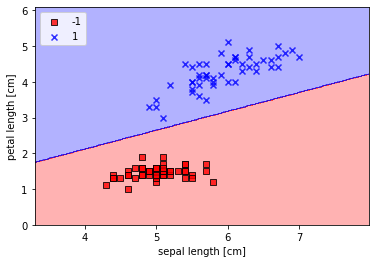

In [6]:
plot_decision_regions(X, y, classifier=ppn)
plt.xlabel('sepal length [cm]')
plt.ylabel('petal length [cm]')
plt.legend(loc='upper left')
plt.show()

## 아달린 구현

- 경사하강법 제시
- **배치 경사하강법**: **전체 훈련 데이터셋**을 기반으로 그레이디언트를 계산

![](images/adaline.jpeg)

In [7]:
class AdalineGD(object):
    def __init__(self, eta=0.01, n_iter=50, random_state=1):
        self.eta = eta
        self.n_iter = n_iter
        self.random_state = random_state
        
    def fit(self, X, y):
        rgen = np.random.RandomState(self.random_state)
        self.w_ = rgen.normal(loc=0.0, scale=0.01,
                              size=1 + X.shape[1])
        self.cost_ = []
        
        for i in range(self.n_iter):
            net_input = self.net_input(X)
            output = self.activation(net_input)
            errors = (y - output)
            self.w_[1:] = self.eta * X.T.dot(errors)
            self.w_[0] = self.eta * errors.sum()
            cost = (errors**2).sum() / 2.0
            self.cost_.append(cost)
        return self
    
    def net_input(self, X):
        return np.dot(X, self.w_[1:]) + self.w_[0]  # sigma(x * w) + w0
    
    def activation(self, X):
        return X
    
    def predict(self, X):
        return np.where(self.activation(self.net_input(X)) >= 0.0, 1, -1) 

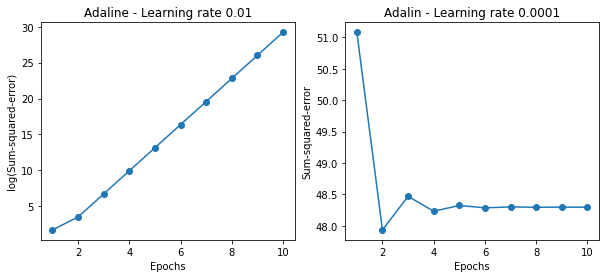

In [8]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(10, 4))
ada1 = AdalineGD(n_iter=10, eta=0.01).fit(X, y)
ax[0].plot(range(1, len(ada1.cost_) + 1), np.log10(ada1.cost_), marker='o')
ax[0].set_xlabel('Epochs')
ax[0].set_ylabel('log(Sum-squared-error)')
ax[0].set_title('Adaline - Learning rate 0.01')

ada2 = AdalineGD(n_iter=10, eta=0.0001).fit(X, y)
ax[1].plot(range(1, len(ada2.cost_) + 1), ada2.cost_, marker='o')
ax[1].set_xlabel('Epochs')
ax[1].set_ylabel('Sum-squared-error')
ax[1].set_title('Adalin - Learning rate 0.0001')
plt.show()

### 표준화 후 경사하강법 결과 향상

**교재와 달리 향상되지 않는다!!!**

/var/folders/_8/0hjw1jgs5fx2zkq05jtt6_6w0000gn/T/ipykernel_798/2475110485.py:30: UserWarning: You passed a edgecolor/edgecolors ('black') for an unfilled marker ('x').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  plt.scatter(x=X[y == c1, 0],


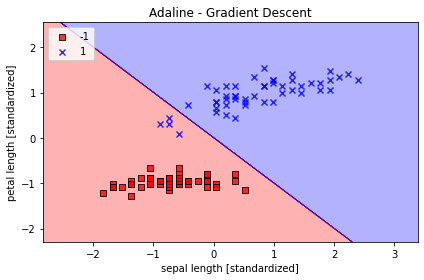

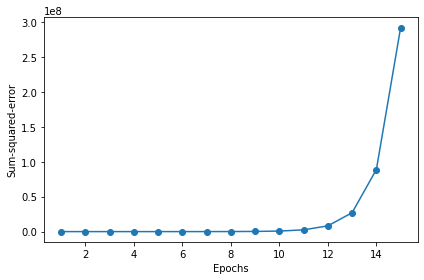

In [9]:
X_std = np.copy(X)
X_std[:, 0] = (X[:, 0] - X[:, 0].mean()) / X[:, 0].std()
X_std[:, 1] = (X[:, 1] - X[:, 1].mean()) / X[:, 1].std()

ada = AdalineGD(n_iter=15, eta=0.01)
ada.fit(X_std, y)

plot_decision_regions(X_std, y, classifier=ada)
plt.title('Adaline - Gradient Descent')
plt.xlabel('sepal length [standardized]')
plt.ylabel('petal length [standardized]')
plt.legend(loc='upper left')
plt.tight_layout()
plt.show()

plt.plot(range(1, len(ada.cost_) + 1), ada.cost_, marker='o')
plt.xlabel('Epochs')
plt.ylabel('Sum-squared-error')
plt.tight_layout()
plt.show()

### 확률적 경사하강법

- **하나의 훈련 샘플**을 기반으로 그레이디언트 계산
- 매 에포크 전에 훈련 샘플 섞기

![](images/sgd.jpg)

In [10]:
class AdalineSGD(object):
    def __init__(self, eta=0.01, n_iter=10,
                 shuffle=True, random_state=None):
        self.eta = eta
        self.n_iter = n_iter
        self.w_initialized = False
        self.shuffle = shuffle
        self.random_state = random_state
        
    def fit(self, X, y):
        self._initialize_weights(X.shape[1])
        self.cost_ = []
        for i in range(self.n_iter):
            if self.shuffle:
                X, y = self._shuffle(X, y)
            cost = []
            for xi, target in zip(X, y):
                cost.append(self._update_weights(xi, target))
            avg_cost = sum(cost) / len(y)
            self.cost_.append(avg_cost)
        return self
    
    def partial_fit(self, X, y):
        if not self.w_initialized:
            self._initialize_weights(X.shape[1])
        if y.ravel().shape[0] > 1:
            for xi, target in zip(X, y):
                self._update_weights(xi, target)
        else:
            self._update_weights(X, y)
        return self
    
    def _shuffle(self, X, y):
        r = self.rgen.permutation(len(y))
        return X[r], y[r]
    
    def _initialize_weights(self, m):
        self.rgen = np.random.RandomState(self.random_state)
        self.w_ = self.rgen.normal(loc=0.0, scale=0.01, size=1 + m)
        self.w_initialized = True
        
    def _update_weights(self, xi, target):
        output = self.activation(self.net_input(xi))
        error = (target - output)
        self.w_[1:] += self.eta * xi.dot(error)
        self.w_[0] += self.eta * error
        cost = 0.5 * error**2
        return cost
    
    def net_input(self, X):
        return np.dot(X, self.w_[1:] + self.w_[0])
    
    def activation(self, X):
        return X
    
    def predict(self, X):
        return np.where(self.activation(self.net_input(X)) >= 0.0, 1, -1)
    
            

/var/folders/_8/0hjw1jgs5fx2zkq05jtt6_6w0000gn/T/ipykernel_798/2475110485.py:30: UserWarning: You passed a edgecolor/edgecolors ('black') for an unfilled marker ('x').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  plt.scatter(x=X[y == c1, 0],


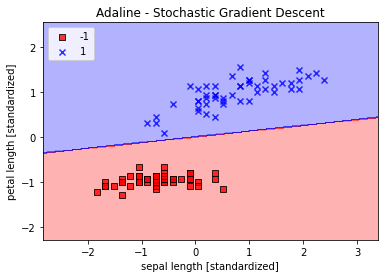

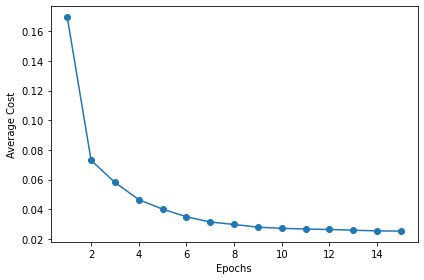

In [11]:
ada = AdalineSGD(n_iter=15, eta=0.01, random_state=1)
ada.fit(X_std, y)

plot_decision_regions(X_std, y, classifier=ada)
plt.title('Adaline - Stochastic Gradient Descent')
plt.xlabel('sepal length [standardized]')
plt.ylabel('petal length [standardized]')
plt.legend(loc='upper left')
plt.show()

plt.plot(range(1, len(ada.cost_) + 1), ada.cost_, marker='o')
plt.xlabel('Epochs')
plt.ylabel('Average Cost')
plt.tight_layout()
plt.show()